 # Final Project


In [1]:
import mdptoolbox
import mdptoolbox.example
import numpy as np
import scipy.constants as sc
import itertools
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from matplotlib import animation
from radar import *
from interference import *
from target import *
from waveform import *



 ### Radar Environment


 The radar environment is defined by a set of possible postion states

 $\mathcal{P}$ and a set of velocity states $\mathcal{V}$.


 $\mathcal{P} = \{\mathbf{r_1}, \mathbf{r_2}, \dots, \mathbf{r_\rho}\}$


 $\mathcal{V} = \{\mathbf{v_1}, \mathbf{v_2}, \dots, \mathbf{v_\nu}\}$


 where $\rho$ is the number of possible position states and $\nu$ is the number

 of possible velocities.


 Each $\mathbf{r_i}, \mathbf{v_i}$ are 3-dimensional row vectors


 $\mathbf{r_i} = \left[r_x, r_y, r_z \right]$


 $\mathbf{v_i} = \left[v_x, v_y, v_z \right]$

 **NOTE:** The current iteration of the simulation only considers the frequency
 environment for the MDP. By not including the target position and velocity, we
 **significantly** reduce training time and the sample support needed for a good
 estimate. The downside to this is that we cannot use the target position in the
 reward function (e.g., through SINR), but initial experimentation suggests that
 this is a suboptimal reward function anyways.

 ### Interference Environment


In [2]:
N = 5
channel_bw = 200e6
subband_bw = channel_bw / N
channel = np.zeros((N,))
# Matrix of all unique interference states, where each row is a unique state and
# each column is a frequency bin
Theta = np.array(list(itertools.product([0, 1], repeat=N)))

# Interfering system
interference_state = 1
comms = HoppingInterference(pattern=np.array(
    [2**n for n in range(N)]), tx_power=4.6e-13, states=Theta)
# comms = IntermittentInterference(
# tx_power=4.6e-13, states=Theta, state_ind=interference_state,
# transition_prob=0)
# comms = ConstantInterference(
#     tx_power=4.6e-13, states=Theta, state_ind=interference_state)



 ## Simulation Environment

 ### Radar and Target Parameters

In [3]:
# Radar system
radar = Radar(position=np.zeros((3,)), prf=2000,
              center_freq=10e9, tx_gain=100, tx_power=1e3, num_pulse_cpi=20)
# Transmitted waveform (linear FM)
wave = LinearFMWaveform(bandwidth=20e6, pulsewidth=10e-6)
# Possible actions (assume transmission over contiguous sub-bands)
actions = np.zeros((0, N))
for i in range(N):
    state = np.zeros((N,))
    state[:i+1] = 1
    actions = np.append(actions, np.array([np.roll(state, j) for j in
                                           range(N-i)]), axis=0)
# Number of position states in each dimension
# TODO: I don't know if these need to exist anymore
rho_x = 5
rho_y = 5
rho_z = 1
rho = rho_x*rho_y*rho_z
rx = np.linspace(-5e3, 5e3, rho_x)
ry = np.linspace(1e3, 5e3, rho_y)
rz = np.linspace(0, 0, rho_z)
P = np.vstack(np.meshgrid(rx, ry, rz)).reshape(3, -1).T
# Number of velocity states
nu_x = 3
nu_y = 3
nu_z = 1
nu = nu_x*nu_y*nu_z
# NOTE: The min/max velocity I have set in each dimension is completely arbitrary
vx = np.linspace(-5, 5, nu_x)
vy = np.linspace(-5, 5, nu_y)
vz = np.linspace(0, 0, nu_z)
V = np.vstack(np.meshgrid(vx, vy, vz)).reshape(3, -1).T
target = Target(position=[], velocity=[], rcs=0.1)




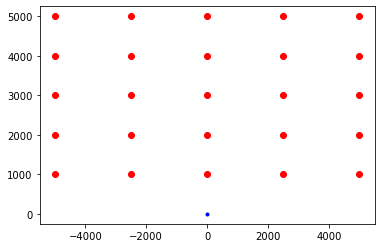

In [4]:
plt.plot(P[:, 0], P[:, 1], 'ro', label='Position States')
plt.plot(radar.position[0], radar.position[1], 'b.', label='Radar Position')



 ### Reward structure


In [5]:
def reward(radar_state, interference_state):
    r = 0
    # Number of collisions with the interference
    num_collision = np.sum(np.equal(radar_state, 1) &
                           (radar_state == interference_state))
    # Number of sub-bands utilized by the radar
    num_subband = np.sum(radar_state)
    # Number of missed opportunities for radar transmission, where no
    # interference exists but the radar did not transmit there
    num_missed_opportunity = np.sum(
        (radar_state == 0) & (interference_state == 0))

    if (num_collision > 0):
        r += -100*num_collision
    else:
        r += 10*(num_subband-1)
    return r

    # TODO: Penalize rapid waveform changes



In [6]:
def reward(radar_state, interference_state):
    r = 0
    # Number of collisions with the interference
    num_collision = np.sum(np.equal(radar_state,1) & (radar_state == interference_state))
    # Number of sub-bands utilized by the radar
    num_subband = np.sum(radar_state)
    # Number of missed opportunities for radar transmission, where no
    # interference exists but the radar did not transmit there
    num_missed_opportunity = np.sum(
        (radar_state == 0) & (interference_state == 0))

    if (num_collision > 0):
        r += -100*num_collision
    else:
        r += 10*(num_subband-1)
    return r

    # TODO: Penalize rapid waveform changes




In [7]:
def animate_spectrum(tx_history, interference_history):
    # tx: array of radar transmission actions, where each row is the spectrum
    # state for a test run
    # int: Array of interference states with the same shape as for the transmission

    def animate(i):
        radar_action = tx_history[i, :]
        interference_state = interference_history[i, :]
        for ibin in range(len(radar_spectrum.patches)):
            # Get the histogram bin object
            bin = radar_spectrum.patches[ibin]
            int_bin = interference.patches[ibin]
            # Set the height of each bin
            bin.set_height(radar_action[ibin])
            int_bin.set_height(interference_state[ibin])
            # Set the color of each bin based on whether or not a collision exists
            if radar_action[ibin] == interference_state[ibin]:
                bin.set_color('r')
                int_bin.set_color('r')
            else:
                bin.set_color('b')
                int_bin.set_color('g')

        return radar_spectrum.patches

    fig, ax = plt.subplots()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('State')
    subband_bw_mhz = subband_bw / 1e6
    interference = plt.bar(np.arange(N)*subband_bw_mhz, np.ones(
        (N,)), width=subband_bw_mhz, edgecolor='k', color='g', align='edge')
    radar_spectrum = plt.bar(
        np.arange(N)*subband_bw_mhz, np.ones((N,)), width=subband_bw_mhz,
        edgecolor='k', color='b', align='edge')
    anim = animation.FuncAnimation(
        fig, animate, tx_history.shape[0], repeat=False, blit=True)
    anim.save('test.gif', fps=1)



 ## Train the MDP

In [8]:
# Number of possible states (here, equal to the number of interference states)
S = 2**(2*N)
# Number of possible actions
A = actions.shape[0]
# Initialize the transition and reward matrices
T = np.zeros((A, S, S))
R = np.zeros((A, S, S))

num_train = int(1e3)
num_test = int(1)
time = np.linspace(0, 1500, len(comms.pattern))
# Time step for the simulation
dt = time[1] - time[0]
for itrain in range(num_train):
    # Randomly select a starting position and target velocity
    target.position = P[np.random.choice(P.shape[0]), :]
    target.velocity = V[np.random.choice(V.shape[0]), :]
    # Add a gaussian perturbance to the position and velocity
    target.position += np.random.randn()
    target.velocity += np.random.randn()
    target.position[-1] = max(target.position[-1], 0)
    next_state = (0, comms.state_ind)
    for t in time:
        # Initial environment state
        current_state = next_state
        # Randomly select a valid action
        action_index = np.random.randint(0, A)
        radar.action = actions[action_index, :]

        # Determine the bandwidth used, then update the interference, position, range, and SINR
        wave.bandwidth = subband_bw*np.sum(radar.action)
        comms.step()
        target.step(dt)
        next_state = (current_state[1], comms.state_ind)
        # We also need the indices of the interference state (with memory) in
        # the Theta array
        current_state_ind = current_state[0]*(2**N) + current_state[1]
        next_state_ind = next_state[0]*(2**N) + next_state[1]
        T[action_index, current_state_ind, next_state_ind] += 1
        R[action_index, current_state_ind,
            next_state_ind] += reward(radar.action, comms.current_state)

# Normalize the transition probability matrix to make it stochastic
T = np.array([normalize(T[a], axis=1, norm='l1') for a in range(A)])
# Also need to add a 1 to the diagonals of the matrices where the probability is zero
for a in range(A):
    ind = np.where(T[a].sum(axis=1) == 0)[0]
    for i in ind:
        T[a, i, i] = 1
        R[a, i, i] = 0

# Use policy iteration to determine the optimal policy
pi = mdptoolbox.mdp.PolicyIteration(T, R, 0.9)
pi.run()



   ## Test the MDP

In [9]:
current_reward = np.zeros((time.shape[0], num_test))
current_sinr = np.zeros((time.shape[0], num_test))
for itest in range(num_test):
    # Select a NEW trajectory that was not used for training
    # Randomly select a starting position and target velocity
    target.position = np.random.rand(3)*(np.max(P)-np.min(P)) + np.min(P)
    target.velocity = np.random.rand()*(np.max(V)-np.min(V)) + np.min(V)

    tx_history = np.empty((0, N))
    interference_history = np.empty((0, N))
    next_state = (0, comms.state_ind)
    for itime in range(time.shape[0]):
        # Initial environment state
        current_state = next_state
        current_state_ind = current_state[0]*(2**N) + current_state[1]
        # Select an action from the policy
        radar.action = actions[pi.policy[current_state_ind], :]

        # Determine the bandwidth used, then update the interference, position, range, and SINR
        wave.bandwidth = subband_bw*np.sum(radar.action)
        comms.step()
        target.step(dt)
        if itime > 0:
            current_reward[itime, itest] = current_reward[itime -
                                                          1, itest] + reward(radar.action, comms.current_state)
        next_state = (current_state[1], comms.state_ind)

        # Variables for plotting
        interference_history = np.append(interference_history, np.reshape(
            Theta[comms.state_ind], (1, N)), axis=0)
        tx_history = np.append(tx_history, np.reshape(
            radar.action, (1, N)), axis=0)
        sinr = radar.SINR(target, comms, wave)
        current_sinr[itime, itest] = sinr

current_reward = np.mean(current_reward, axis=1)
current_sinr = np.mean(current_sinr, axis=1)



   ## Visualizations

MovieWriter ffmpeg unavailable; using Pillow instead.


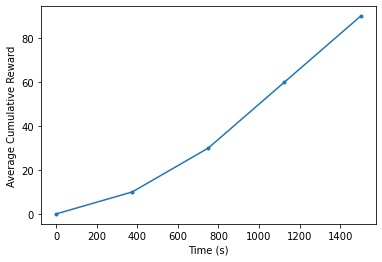

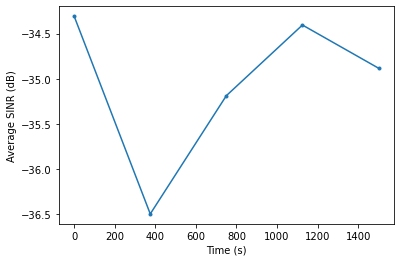

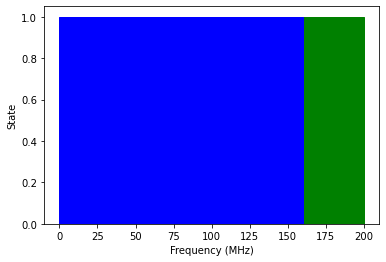

In [10]:
plt.figure()
plt.plot(time, current_reward, '.-')
plt.xlabel('Time (s)')
plt.ylabel('Average Cumulative Reward')
plt.savefig('reward')

plt.figure()
plt.plot(time, current_sinr, '.-')
plt.xlabel('Time (s)')
plt.ylabel('Average SINR (dB)')
plt.savefig('SINR')
animate_spectrum(tx_history, interference_history)



